In [2]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from multiprocessing import Pool

# Approach 1: just cluster on the input variables
X_NUM_COLS = [
    'is_ns', 'is_inbound', 'is_rapid', 'is_weekend', 'trip_start_hr_15', 'orca_total', 
    'frac_disabled', 'frac_youth', 'frac_senior', 'frac_li', 'frac_uw', 'HourlyDryBulbTemperature', 
    'HourlyPrecipitation', 'HourlyRelativeHumidity', 'HourlySeaLevelPressure', 'HourlyWindSpeed'
]


# Treat the time-series of ons over the sample period.
# Some routes have less data. But because the routes have different frequencies there are some times when less-used routes didn't run.
# And remember the rotues are going to have multiple

train = pd.read_csv('../winter_data/aggregates/15min/train.tsv.gz', sep='\t')

def clust(k):
    print(k)
    km = KMeans(k)
    preds = km.fit_predict(train[X_NUM_COLS])
    return  km.inertia_

with Pool(4) as p:
    inertia = p.map(clust, range(3, 20))   


3
5
7
9
4
6
8
10
11
13
15
17
12
14
16
19
18


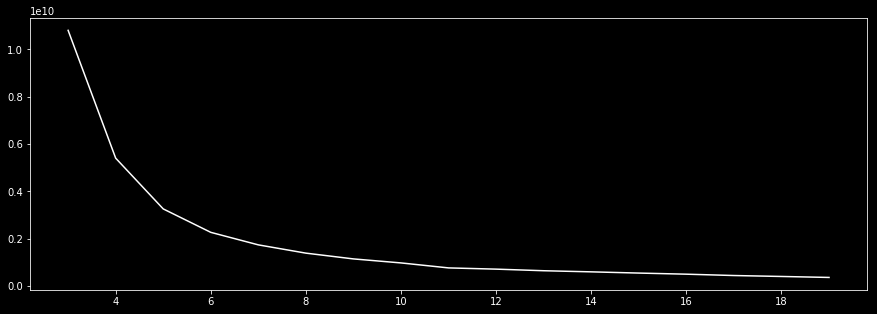

In [17]:

plt.style.use('dark_background')
plt.figure(figsize=(15,5))
plt.plot(list(range(3, 20)), inertia, color='white')
plt.show()  # 6 seems to be the best number of clusters

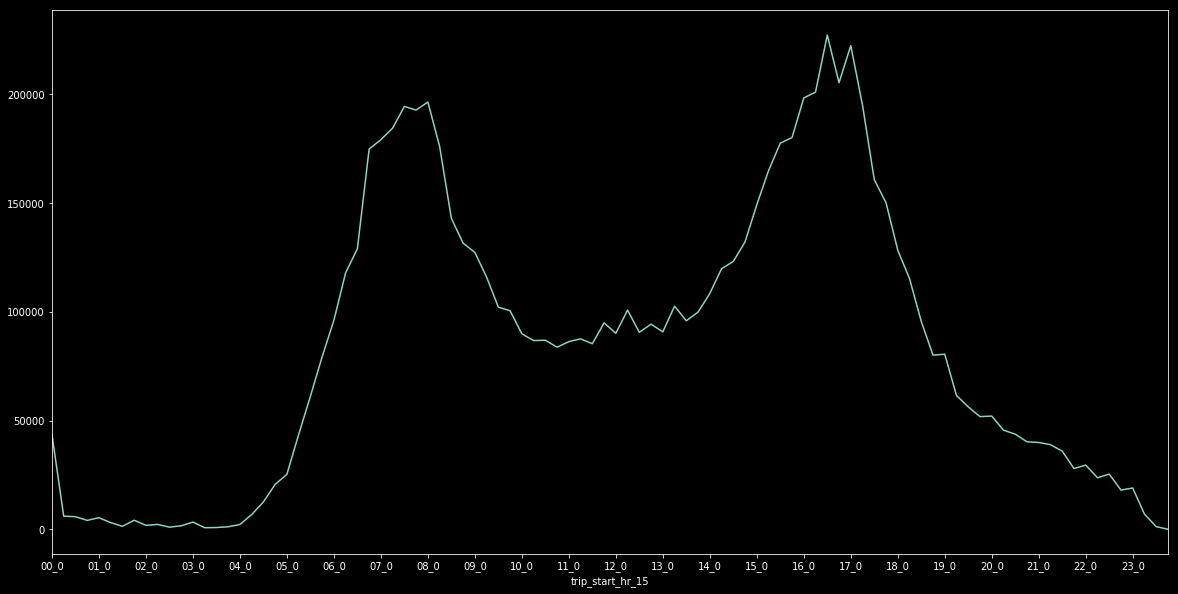

In [5]:
# What are the common times?
import matplotlib.ticker as ticker
plt.style.use('dark_background')
fig, ax = plt.subplots(1,1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
train[train['is_weekend']==0.0].groupby('trip_start_hr_15')['ons'].sum().plot(figsize=(20, 10))
plt.show()
# EARLY AM: midnight - 4am (00_0 to 03_2)
# AM PEAK: 4am - 10am (04_0 to 09_2)
# MIDDAY: 10am - 3pm (10_0 to 14_2)
# PM PEAK: 3pm - 7pm (15_0 to 18_2)
# EVENING: 7pm - midnight (19_0 to 23_3)


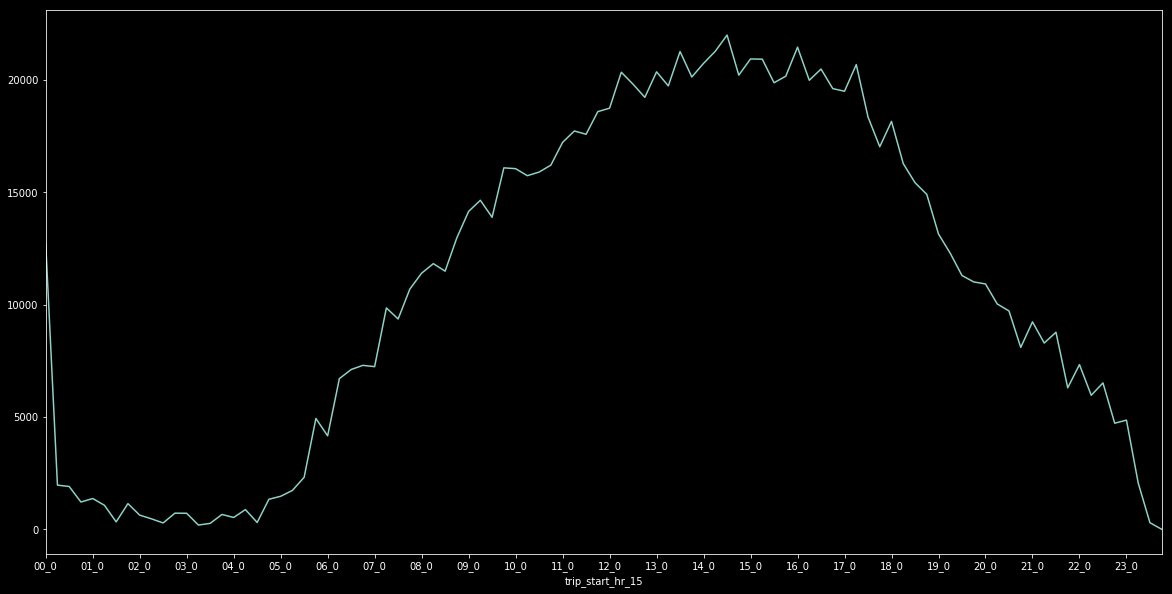

In [6]:
# What are the common times?

fig, ax = plt.subplots(1,1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
train[train['is_weekend']==1.0].groupby('trip_start_hr_15')['ons'].sum().plot(figsize=(20, 10))
plt.show()


In [21]:

train['timeblock'] = np.nan
train['hr'] = train['trip_start_hr_15'].apply(lambda x: int(x.split('_')[0]))
train.loc[train['hr'] < 4, 'timeblock'] = 'Early Morning'
train.loc[(train['hr'] >= 4) & (train['hr'] < 10), 'timeblock'] = 'Morning Peak'
train.loc[(train['hr'] >= 10) & (train['hr'] < 15), 'timeblock'] = 'Midday'
train.loc[(train['hr'] >= 15) & (train['hr'] < 19), 'timeblock'] = 'Evening Peak'
train.loc[(train['hr'] >= 19), 'timeblock'] = 'Night'
print(train['timeblock'].value_counts())

Morning Peak     66739
Midday           60900
Evening Peak     58230
Night            38242
Early Morning     7453
Name: timeblock, dtype: int64


In [29]:
km = KMeans(6)
train['cluster'] = km.fit_predict(train[X_NUM_COLS])

rte_clusters = train.groupby('rte')['cluster'].idxmax().apply(lambda x: train.loc[x, 'cluster']).reset_index()
rte_clusters.cluster.value_counts()

5    118
4     51
Name: cluster, dtype: int64

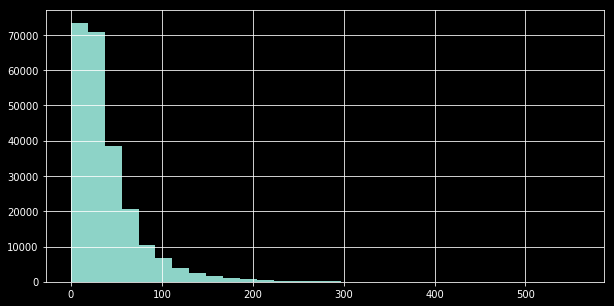

In [21]:
# another idea, just look at the distribution of ons
train.ons.hist(bins=30, figsize=(10,5))
plt.show()

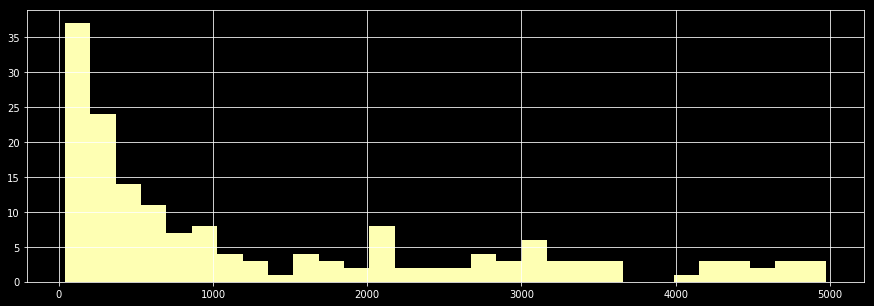

In [31]:
# What about the frequency of trips?
train.rte.value_counts().hist(bins=30, figsize=(15,5))
plt.show()

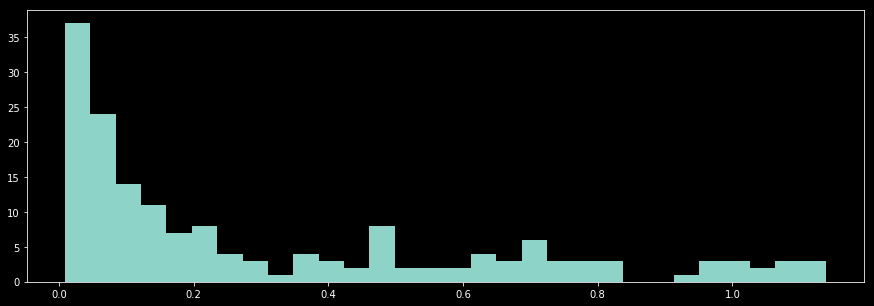

In [52]:
rte_clusters = train.rte.value_counts().reset_index().rename(columns={'rte': 'ntrips', 'index':'rte'})
n_15_min_periods = len((train.trip_start_hr_15 + train.opd_date).unique())
rte_clusters['trips_per_15'] = (rte_clusters['ntrips'] / n_15_min_periods)
plt.figure(figsize=(15,5))
plt.hist(rte_clusters['trips_per_15'], bins=30)
plt.show()

In [57]:
rte_clusters['trip_freq'] = rte_clusters['trips_per_15'].apply(lambda trprate: 'low' if trprate <= 0.25 else ('med' if trprate <= 0.85 else 'high'))
rte_clusters
# low: < 1 trip per hour
# med: anything in between
# high:  about 1 trip per 15 minutes
print(rte_clusters.trip_freq.value_counts())
rte_clusters.to_csv("rte_clusters.tsv", sep='\t', index=False)

low     101
med      53
high     15
Name: trip_freq, dtype: int64


,rte,ntrips,trips_per_15,trip_freq
0,48,4975,1.138965,high
1,45,4893,1.120192,high
2,674,4831,1.105998,high
3,675,4782,1.094780,high
4,673,4753,1.088141,high
5,62,4707,1.077610,high
6,8,4539,1.039148,high
7,671,4528,1.036630,high
8,36,4480,1.025641,high
9,7,4407,1.008929,high


rte
73     0.458647
105    0.447528
249    0.369928
22     0.344595
347    0.343567
24     0.321595
346    0.314171
128    0.308642
45     0.296750
208    0.296748
124    0.285595
180    0.283623
48     0.278392
150    0.275563
132    0.275476
131    0.269358
671    0.268330
26     0.267799
62     0.267686
248    0.267600
238    0.262376
673    0.261940
675    0.260351
50     0.259889
522    0.257724
28     0.254708
236    0.252914
372    0.251819
181    0.250000
676    0.248550
         ...   
216    0.000000
122    0.000000
57     0.000000
123    0.000000
214    0.000000
153    0.000000
212    0.000000
204    0.000000
201    0.000000
143    0.000000
218    0.000000
219    0.000000
224    0.000000
102    0.000000
268    0.000000
257    0.000000
63     0.000000
64     0.000000
252    0.000000
179    0.000000
154    0.000000
244    0.000000
243    0.000000
74     0.000000
237    0.000000
76     0.000000
77     0.000000
78     0.000000
232    0.000000
246    0.000000
Name: is_weekend, Le

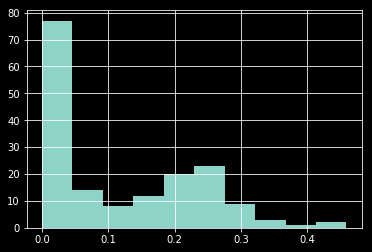

In [67]:
train['is_weekend'] = train['day_of_week'].isin((5,6))
print(train.groupby('rte')['is_weekend'].mean().sort_values(ascending=False))
train.groupby('rte')['is_weekend'].mean().sort_values(ascending=False).hist()
plt.show()